In [1]:
!pip install tensorflow opencv-python matplotlib

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# plt.imshow?? this allows us to display data as an image
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [10]:
# Uncompress Tor GZ Labeled Faces in the wild Dataset
!tar -xf lfw.tgz

In [11]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    directory_path = os.path.join('lfw', directory)
    for file in os.listdir(directory_path):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [4]:
# Import uuid library to generate unique image names
import uuid

In [7]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250px X 250px
    frame = frame[80:80+250, 250:250+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create a unique file name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create a unique file name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
        
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
cv2.destroyAllWindows()

In [35]:
# show the last image frame
# plt.imshow(frame[150:150+250, 250:250+250, :])

In [8]:
# Get Image directories

anchor = tf.data.Dataset.list_files(ANC_PATH + '\\*.jpg').take(900)
positive = tf.data.Dataset.list_files(POS_PATH + '\\*.jpg').take(900)
negative = tf.data.Dataset.list_files(NEG_PATH + '\\*.jpg').take(900)

In [9]:
dir_test = anchor.as_numpy_iterator()

In [10]:
dir_test.next()

b'data\\anchor\\b1dfd3d1-2efe-11ef-acd6-3ca067afbd34.jpg'

In [11]:
# Preprocessing - Scale and Resize
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Loading the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to 100px X 100px X 3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [12]:
img = preprocess(dir_test.next())

In [13]:
img.numpy().max()

0.9051471

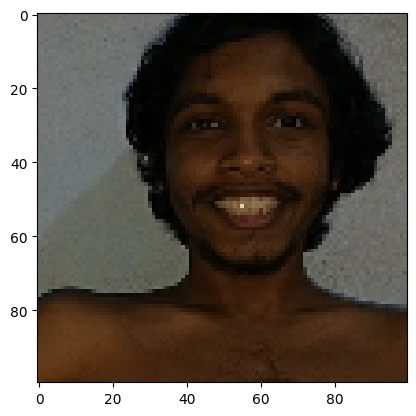

In [14]:
plt.imshow(img)

In [85]:
# Create Labelled Dataset
# (anchor, positive) => [1, 1, 1, 1, 1] this will be 1 of len(positive)
# (anchor, negative) => [0, 0, 0, 0, 0] this will be 0 of len(negative)

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
# Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [19]:
# Training partition
train_data = data.take(round(len(data)*.7)) # take 70% of elements to train
train_data = train_data.batch(16) # For efficient training and computational performance, as it allows the model to process multiple examples in parallel.
train_data = train_data.prefetch(8) # The pipeline will prepare the next 8 batches while the current batch is being processed by the model.

In [20]:
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [21]:
# Build Embedding Layer

def make_embedding():
    inp = Input(shape=(100,100,3), name = 'input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation = "relu")(m2)
    f1 = Flatten()(c4) # This will convert our multidimentional arrays to 1D array
    # Dense layer commonly use when the output is typically a fixed size vector. this is the hidden layer it has 4096 neurones.
    d1 = Dense(4096, activation = "sigmoid")(f1)

    return Model(inputs=[inp], outputs=d1, name='embedding')

In [22]:
embedding = make_embedding()

In [23]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Build Distance Layer
# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [25]:
something = L1Dist()

In [26]:
something

<L1Dist name=l1_dist, built=False>

In [27]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [28]:
inp_emb = embedding(input_image)
val_emb = embedding(validation_image)

In [29]:
siamese_layer = L1Dist()

In [30]:
siamese_layer(inp_emb, val_emb)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_11>

In [31]:
# Make Siamese Model
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combinr siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [32]:
siamese_model = make_siamese_model()

In [33]:
# Training
# Setup loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [34]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001 learning rate

In [35]:
# Establish Check Points
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model=siamese_model)

In [36]:
checkpoint

In [37]:
# Build Train Step Function

# Record all of operations
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        x = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(x, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

# One disadvantage to actually traing this way is you have to go and define 
# all of your progress and all of your loss metrics being output 

In [38]:
# Building training Loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train data here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [39]:
# Train the model
EPOCHS = 50

In [40]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
78/79 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
79/79 ━━━━━━━━━━━━━━━━━━━━ 450s 6s/step

 Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 442s 6s/step

 Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step

 Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 438s 6s/step

 Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step

 Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step

 Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step

 Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 437s 6s/step

 Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 482s 6s/step

 Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 456s 6s/step

 Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 503s 6s/step

 Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 483s 6s/step

 Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 436s 6s/step

 Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 433s 5s/step

 Epoch 15/50
79/79 

In [41]:
# Evaluate Model
# Import metrix Calculations
from tensorflow.keras.metrics import Precision, Recall

In [42]:
# Make Predictions
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [43]:
# Make Predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[9.9998367e-01],
       [5.2737231e-08],
       [9.9964249e-01],
       [9.9999702e-01],
       [1.0000000e+00],
       [9.9999952e-01],
       [9.9999964e-01],
       [9.9941599e-01],
       [9.9999958e-01],
       [1.4308498e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999344e-01],
       [1.0000000e+00],
       [9.9997866e-01],
       [2.2567704e-06]], dtype=float32)

In [44]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]

In [45]:
# Calculate Metrix
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [46]:
# Creating metric Object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

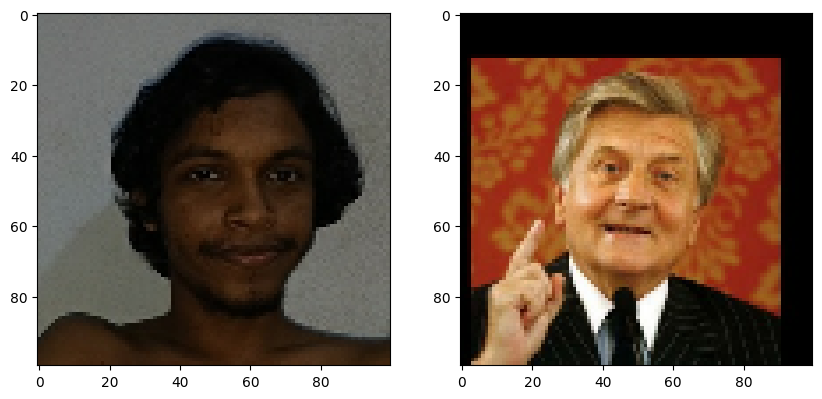

In [51]:
## Visualize images

# Set the plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[9])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[9])

# Renders clearly
plt.show()

In [52]:
## Save model

# Save weights
siamese_model.save("siamesemodel.keras")
# keras.saving.save_model(siamese_model, 'mymodel.keras')

In [53]:
# Reload Model
model = tf.keras.models.load_model('siamesemodel.keras',
                                  custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [54]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[9.9998367e-01],
       [5.2737231e-08],
       [9.9964249e-01],
       [9.9999702e-01],
       [1.0000000e+00],
       [9.9999952e-01],
       [9.9999964e-01],
       [9.9941599e-01],
       [9.9999958e-01],
       [1.4308498e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999344e-01],
       [1.0000000e+00],
       [9.9997866e-01],
       [2.2567704e-06]], dtype=float32)

In [55]:
[1 if prediction > 0.5 else 0 for prediction in model.predict([test_input, test_val])]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]

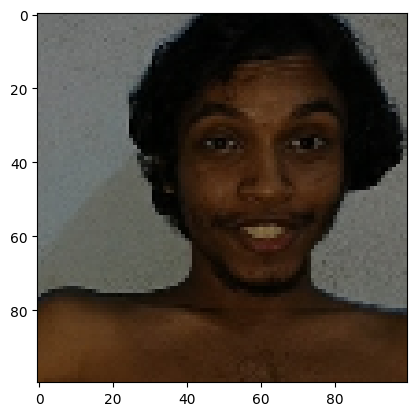

In [56]:
plt.imshow(test_input[14])

In [57]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
## Real time test

In [59]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / Total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification >= verification_threshold

    return results, verified
    

In [71]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input to folder
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.6, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 